# Classification & Regression

- Motivation
- Problem Definition
- Data Observation
- Preprocessing (Feature Engineering)
- Model Training
- Model Testing 
- Cross Validation (Not in this lecture)
- Back to Step 1, 2, 3 or 4

In [1]:
%matplotlib inline
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

## Problem Definition
- Input:  前 x_len 個小時的電力資訊
- Output: 後 y_len 個小時的北部電力使用量

## Preprocessing
### 資料清理

In [2]:
df_power = pd.read_csv('power.csv')
df_power.head()

,Date,Time,NorthSupply,NorthUsage,CenterSupply,CenterUsage,SouthSupply,SouthUsage,EastSupply,EastUsage
0,2016-09-27,12:10,648.4,841.3,733.0,564.4,839.6,799.9,14.0,29.3
1,2016-09-27,13:10,601.3,826.4,725.4,535.9,827.3,777.9,14.0,27.6
2,2016-09-27,14:00,500.9,789.5,759.0,506.7,821.5,771.3,13.9,27.9
3,2016-09-27,15:10,516.1,773.6,717.1,450.8,744.2,737.3,13.9,29.5
4,2016-09-27,16:00,530.2,778.0,691.6,432.2,746.0,735.3,8.7,31.0


In [3]:
# get all PowerSupply data of (North)Taipei from Power.csv
df_power['Datetime'] = df_power["Date"] + " " + df_power['Time']
df = df_power.loc[df_power.Datetime >= '2016-01-01 00:00']
df = df.loc[df.Datetime <= '2017-12-31 23:59', :]
df['Datetime'] = pd.to_datetime(df['Datetime'])
# eliminate duplicate index value
df = df.drop_duplicates(subset='Datetime', keep='last').set_index('Datetime')

df = df.resample('H').pad().bfill()
df = df.drop(['Date', 'Time'], axis=1)
df.head()

,NorthSupply,NorthUsage,CenterSupply,CenterUsage,SouthSupply,SouthUsage,EastSupply,EastUsage
Datetime,,,,,,,,
2016-09-27 00:00:00,516.3,708.2,659.1,477.2,699.7,658.4,4.7,36.0
2016-09-27 01:00:00,516.3,708.2,659.1,477.2,699.7,658.4,4.7,36.0
2016-09-27 02:00:00,515.0,672.2,598.3,456.0,689.4,644.8,4.7,34.3
2016-09-27 03:00:00,466.7,640.5,511.1,430.5,742.5,621.3,4.7,32.7
2016-09-27 04:00:00,434.6,622.4,489.1,421.5,766.1,617.2,4.7,33.4


第二張圖的意思是將資料做shift,

1 : 第一個小時用電量(X_feature)

2 : 第二個小時用電量(X feature)

3 : 第三個小時用電量(要預測得值)

第三張圖是抓取Monday/Tuesday/Wednesday ...

使用One-hot encoding

### 提取特徵
- 加入時間相關資料: Day of Week, Hour of Day

![title](./img.png)

In [4]:
x_len = 24
y_len = 6
time_feature = True
feature_list = ['NorthUsage']

def feature_extract(df, y_target, x_len=3, y_len=1, time_feature=True):
    old_columns = df.columns
    f_len = len(old_columns)
    df = pd.concat([df.shift(-i) for i in range(x_len + y_len)], axis=1)
    df.columns = [c + " " + str(i).zfill(3) for i in range(x_len + y_len) for c in old_columns]
    df = df.head(df.shape[0] - x_len - y_len)
    
    if time_feature:
        df = pd.concat(
            [
                df,
                pd.get_dummies(df.index.to_series().dt.dayofweek, prefix="DOW"),
                pd.get_dummies(df.index.to_series().dt.hour, prefix="HOD")
            ],
            axis=1
        )

    y = df[[c for c in df.columns if y_target in c][-y_len:]]
    X = df.drop(y.columns, axis=1)
    
    return X, y



df = df[feature_list]
df.head()

,NorthUsage
Datetime,
2016-09-27 00:00:00,708.2
2016-09-27 01:00:00,708.2
2016-09-27 02:00:00,672.2
2016-09-27 03:00:00,640.5
2016-09-27 04:00:00,622.4


In [5]:
X, y = feature_extract(df, "NorthUsage", x_len, y_len, time_feature=time_feature)
X.head()


,NorthUsage 000,NorthUsage 001,NorthUsage 002,NorthUsage 003,NorthUsage 004,NorthUsage 005,NorthUsage 006,NorthUsage 007,NorthUsage 008,NorthUsage 009,...,HOD_14,HOD_15,HOD_16,HOD_17,HOD_18,HOD_19,HOD_20,HOD_21,HOD_22,HOD_23
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-09-27 00:00:00,708.2,708.2,672.2,640.5,622.4,622.0,622.1,657.1,657.1,657.1,...,0,0,0,0,0,0,0,0,0,0
2016-09-27 01:00:00,708.2,672.2,640.5,622.4,622.0,622.1,657.1,657.1,657.1,657.1,...,0,0,0,0,0,0,0,0,0,0
2016-09-27 02:00:00,672.2,640.5,622.4,622.0,622.1,657.1,657.1,657.1,657.1,657.1,...,0,0,0,0,0,0,0,0,0,0
2016-09-27 03:00:00,640.5,622.4,622.0,622.1,657.1,657.1,657.1,657.1,657.1,657.1,...,0,0,0,0,0,0,0,0,0,0
2016-09-27 04:00:00,622.4,622.0,622.1,657.1,657.1,657.1,657.1,657.1,657.1,841.3,...,0,0,0,0,0,0,0,0,0,0


HOD : Hour of Day

DOW : Day of Week

In [6]:
X.columns

Index(['NorthUsage 000', 'NorthUsage 001', 'NorthUsage 002', 'NorthUsage 003',
       'NorthUsage 004', 'NorthUsage 005', 'NorthUsage 006', 'NorthUsage 007',
       'NorthUsage 008', 'NorthUsage 009', 'NorthUsage 010', 'NorthUsage 011',
       'NorthUsage 012', 'NorthUsage 013', 'NorthUsage 014', 'NorthUsage 015',
       'NorthUsage 016', 'NorthUsage 017', 'NorthUsage 018', 'NorthUsage 019',
       'NorthUsage 020', 'NorthUsage 021', 'NorthUsage 022', 'NorthUsage 023',
       'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HOD_0',
       'HOD_1', 'HOD_2', 'HOD_3', 'HOD_4', 'HOD_5', 'HOD_6', 'HOD_7', 'HOD_8',
       'HOD_9', 'HOD_10', 'HOD_11', 'HOD_12', 'HOD_13', 'HOD_14', 'HOD_15',
       'HOD_16', 'HOD_17', 'HOD_18', 'HOD_19', 'HOD_20', 'HOD_21', 'HOD_22',
       'HOD_23'],
      dtype='object')

In [7]:
y.head()

,NorthUsage 024,NorthUsage 025,NorthUsage 026,NorthUsage 027,NorthUsage 028,NorthUsage 029
Datetime,,,,,,
2016-09-27 00:00:00,862.5,815.9,815.9,747.8,740.1,724.9
2016-09-27 01:00:00,815.9,815.9,747.8,740.1,724.9,752.0
2016-09-27 02:00:00,815.9,747.8,740.1,724.9,752.0,812.7
2016-09-27 03:00:00,747.8,740.1,724.9,752.0,812.7,716.3
2016-09-27 04:00:00,740.1,724.9,752.0,812.7,716.3,790.4


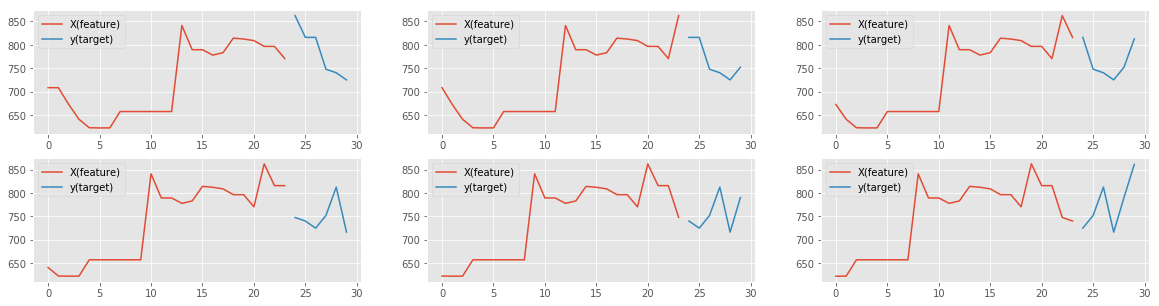

In [8]:
plt.figure(figsize=(20,5))
for i in range (6):
    plt.subplot(231+int(i))
    index_x = np.arange(x_len)
    index_y = np.arange(y_len) + x_len
    #plt.figure()
    plt.plot(index_x,X.iloc[i][[c for c in X.columns if "NorthUsage" in c]],label='X(feature)')
    plt.plot(index_y,y.iloc[i],label='y(target)')
    plt.legend()

In [9]:
# X = (X - X.mean()) / (X.max() - X.min())

## Train, Test Split


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

## Model Training & Testing
### Regression

MultiOutputRegressor(model, njob = -1) : 幫你做model的multiple預測

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score

models_name = [
    'Linear Regression',
    'Decision Tree',
    'Random Forest',
    'AdaBoost'
]

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
]

fitted_models = []

for idx, model in enumerate(models):
    start = time.time()
    model = MultiOutputRegressor(model, n_jobs=-1).fit(X_train, y_train)
    print(models_name[idx])
    y_pred = model.predict(X_test)
    end = time.time()
    
    fitted_models.append(model)
    
    r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_pred.shape[1])]
    [print("Future ", i + 1, " R^2 Err: ", r2_s) for i, r2_s in enumerate(r2_scores)]
    print("Avg R^2 Err: ", np.mean(r2_scores))
    print("Time Cost:", end-start)
    print()

Linear Regression
Future  1  R^2 Err:  0.9669939618810237
Future  2  R^2 Err:  0.940542633059841
Future  3  R^2 Err:  0.9106205112476974
Future  4  R^2 Err:  0.884505669665242
Future  5  R^2 Err:  0.8618737473456726
Future  6  R^2 Err:  0.8371903719884681
Avg R^2 Err:  0.9002878158646576
Time Cost: 0.6454718112945557

Decision Tree
Future  1  R^2 Err:  0.8625303295106913
Future  2  R^2 Err:  0.6413920086663285
Future  3  R^2 Err:  0.7595802638227466
Future  4  R^2 Err:  0.7422175916644624
Future  5  R^2 Err:  0.7232705562621486
Future  6  R^2 Err:  0.7362635180825978
Avg R^2 Err:  0.7442090446681625
Time Cost: 0.8390989303588867

Random Forest
Future  1  R^2 Err:  0.8851751363227984
Future  2  R^2 Err:  0.8428009020528375
Future  3  R^2 Err:  0.841363886442358
Future  4  R^2 Err:  0.8166150835672391
Future  5  R^2 Err:  0.7953952177109056
Future  6  R^2 Err:  0.7887527396683971
Avg R^2 Err:  0.8283504942940892
Time Cost: 3.3193750381469727

AdaBoost
Future  1  R^2 Err:  0.7767725227831

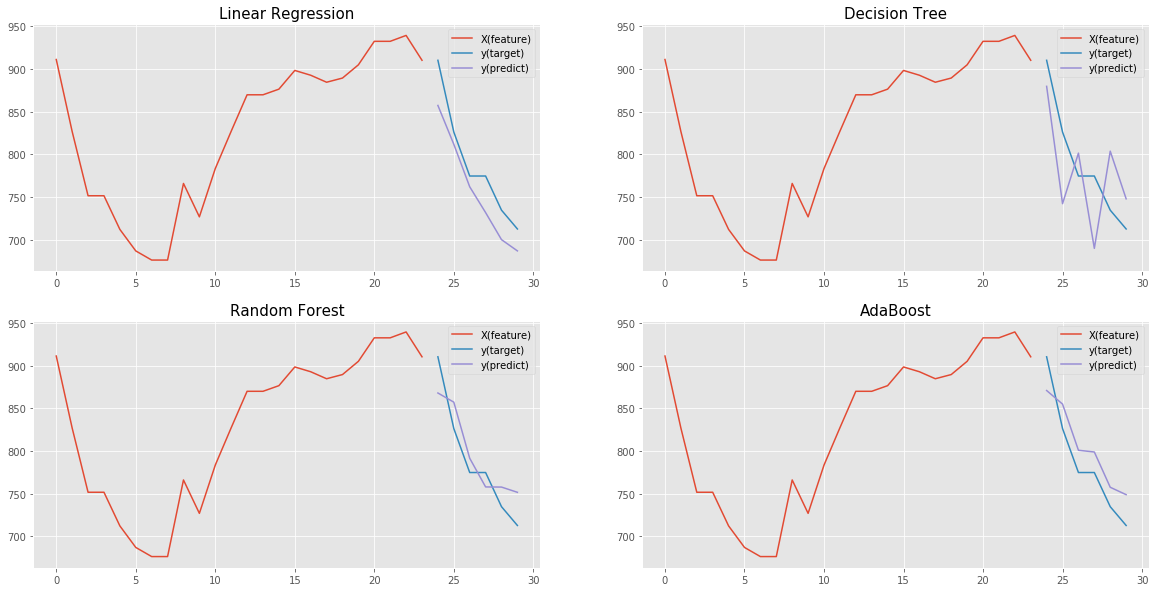

In [12]:
plt.figure(figsize=(20,10))
n = 48
for idx, model in enumerate(fitted_models):
    plt.subplot(221 + idx)
    
    index_x = np.arange(x_len)
    index_y = np.arange(y_len) + x_len
    
    y_pred = model.predict(X_test)
    
    plt.title(models_name[idx],fontsize=15)
    plt.plot(index_x,X_test.iloc[n][[c for c in X.columns if "NorthUsage" in c]],label='X(feature)')
    plt.plot(index_y,y_test.iloc[n],label='y(target)')
    plt.plot(index_y,y_pred[n],label='y(predict)')
    plt.legend()

### Classification

pd.qcut : equal frequency discretization

In [13]:
c_y = y.apply(lambda x: pd.qcut(x, 3, labels=list(range(3))), axis=0)
#c_y.astype('object')
X_train, X_test, y_train, y_test = train_test_split(X, np.array(c_y).astype(int), test_size=0.33, shuffle=False)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
# import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


models_name = [
    'Logistic Regression',
    'Decision Tree', 
    'Random Forest',
    'AdaBoost',
]

models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
]


fitted_models = []

for idx, model in enumerate(models):
    start = time.time()
    model = MultiOutputClassifier(model, n_jobs=-1).fit(X_train, y_train)
    print(models_name[idx])
    y_pred = model.predict(X_test)
    end = time.time()
    
    fitted_models.append(model)

    acc_scores = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(0, y_pred.shape[1])]
    [print("Future ", i + 1, " Acc: ", r2_s) for i, r2_s in enumerate(acc_scores)]
    print("Avg Acc: ", np.mean(acc_scores))
    print("Time Cost:", end-start)
    print()

Logistic Regression
Future  1  Acc:  0.6708907938874394
Future  2  Acc:  0.5814386880357808
Future  3  Acc:  0.5896384644055163
Future  4  Acc:  0.6190831159150205
Future  5  Acc:  0.5657845695117406
Future  6  Acc:  0.5806932538203503
Avg Acc:  0.6012548142626414
Time Cost: 5.807746887207031

Decision Tree
Future  1  Acc:  0.8278046962355572
Future  2  Acc:  0.7733879985091315
Future  3  Acc:  0.7640700708162504
Future  4  Acc:  0.781587774878867
Future  5  Acc:  0.777115169586284
Future  6  Acc:  0.7581065970928066
Avg Acc:  0.780345384519816
Time Cost: 0.7056119441986084

Random Forest
Future  1  Acc:  0.8829668281774133
Future  2  Acc:  0.8281774133432724
Future  3  Acc:  0.8505404398061871
Future  4  Acc:  0.8050689526649273
Future  5  Acc:  0.8218412225121133
Future  6  Acc:  0.8341408870667164
Avg Acc:  0.8371226239284383
Time Cost: 0.8455829620361328

AdaBoost
Future  1  Acc:  0.6328736489004846
Future  2  Acc:  0.8553857622064853
Future  3  Acc:  0.6395825568393589
Future  4  